In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf
import math
from sklearn.model_selection import train_test_split

In [2]:
# Đọc dữ liệu từ file CSV, lấy các cột cần thiết và phân tích cột 'Date' làm chỉ mục
df = pd.read_csv('dataset.csv', usecols=['Date', 'Price', 'Open', 'High', 'Low'])

# Đặt cột Date làm index (thiếu dòng này)
df['Date'] = pd.to_datetime(df['Date'])     # Chuyển sang datetime
df.set_index('Date', inplace=True)

# Loại bỏ các dòng có giá trị thiếu (NaN) trong dữ liệu
df = df.dropna()

print(df.head())

             Price    Open    High     Low
Date                                      
2010-01-04  1118.3  1099.0  1124.6  1093.8
2010-01-05  1118.7  1122.0  1129.6  1115.5
2010-01-06  1136.5  1118.5  1141.0  1116.8
2010-01-07  1133.7  1139.0  1139.5  1128.7
2010-01-08  1138.9  1131.5  1140.0  1119.5


In [3]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        # Lấy đoạn time_step giá trị liên tiếp làm đầu vào X
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        # Giá trị tiếp theo làm đầu ra Y (chỉ dự đoán giá Price)
        dataY.append(dataset[i + time_step, 0])  # Cột 0 là Price
    return np.array(dataX), np.array(dataY)

In [4]:
# Dùng MinMaxScaler để chuẩn hóa về [0, 1] cho tất cả các cột đầu vào
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(df[['Price', 'Open', 'High', 'Low']])

# Lưu dữ liệu đã được chuẩn hóa
scaled_data = features_scaled

# Thiết lập tham số thời gian
time_step = 10

# Phân chia dữ liệu thành train và test
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data = scaled_data[0:train_size]
test_data = scaled_data[train_size:len(scaled_data)]

# Tạo dataset cho train và test
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# X_train và X_test đã có shape [samples, time steps, features=4]
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3122, 10, 4), y_train shape: (3122,)
X_test shape: (773, 10, 4), y_test shape: (773,)
X_train shape: (3122, 10, 4), y_train shape: (3122,)
X_test shape: (773, 10, 4), y_test shape: (773,)


In [5]:
from keras.regularizers import l2
# Tạo mô hình LSTM với 4 features đầu vào
model = Sequential()
model.add(LSTM(
    units=128,
    return_sequences=True,
    input_shape=(time_step, 4),  # 4 features: Price, Open, High, Low
    activation='tanh',
    kernel_regularizer=l2(0.00005)
))

# from keras.layers import Dropout
# model.add(Dropout(0.2))  # Thêm Dropout để giảm overfitting

model.add(LSTM(
    units=64,
    return_sequences=False,
    activation='tanh',
    kernel_regularizer=l2(0.00005)
))

# model.add(Dropout(0.2))  # Thêm Dropout sau LSTM thứ hai

# Thêm các lớp Dense phức tạp hơn
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.00005)))  # Tăng từ 25 lên 32 neurons
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.00005)))  # Thêm một lớp Dense trung gian
model.add(Dense(1))  # Output vẫn là dự đoán giá (Price)

# Biên dịch mô hình
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Sử dụng Adam với learning rate và decay
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Thêm early stopping và reduce learning rate để tránh overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.00001
)

# Huấn luyện mô hình với batch size lớn hơn và callbacks
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,  # Tăng batch size để tránh overfitting
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


c:\Users\HUNG\anaconda3\envs\uitktdl\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0131 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.5258e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5338e-04 - val_loss: 8.3166e-04 - learning_rate: 0.0010
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1139e-04 - val_loss: 8.5237e-04 - learning_rate: 0.0010
Epoch 10/50
79/79 

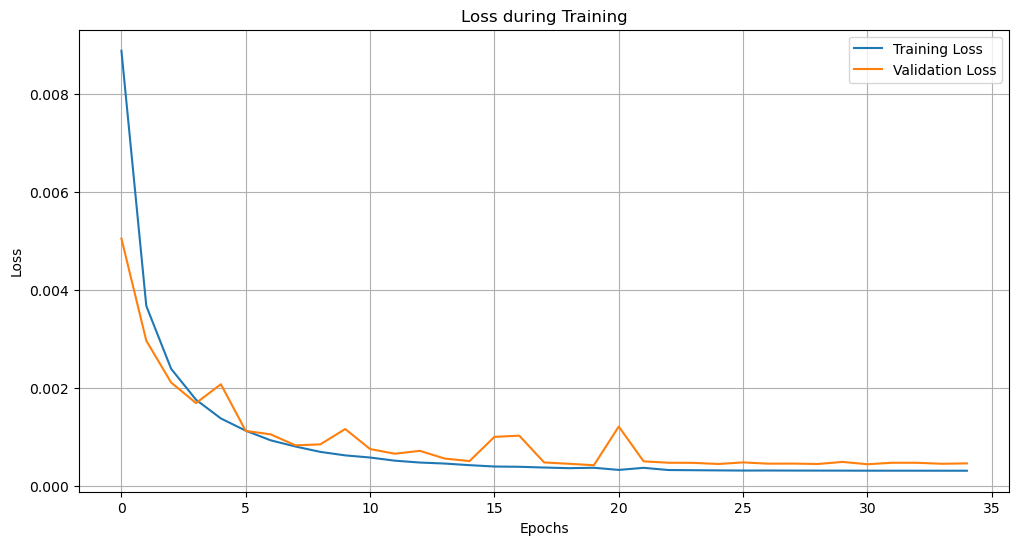

In [6]:
# Vẽ biểu đồ loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# Dự đoán trên tập test
predictions = model.predict(X_test)

# Chuyển đổi giá trị dự đoán và thực tế về thang đo ban đầu
# Cần tạo ma trận giả để sử dụng inverse_transform với chỉ một cột (Price)
# Tạo mảng giả có 4 cột cho inverse_transform
dummy_array = np.zeros((len(predictions), 4))
dummy_array[:,0] = predictions.flatten()  # Đặt giá trị dự đoán vào cột đầu tiên (Price)
predictions_rescaled = scaler.inverse_transform(dummy_array)[:,0].reshape(-1, 1)

# Tương tự cho giá trị thực tế
dummy_array_y = np.zeros((len(y_test), 4))
dummy_array_y[:,0] = y_test  # Đặt giá trị thực tế vào cột đầu tiên (Price)
y_test_rescaled = scaler.inverse_transform(dummy_array_y)[:,0].reshape(-1, 1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [8]:
# Đánh giá mô hình
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# Tính toán các chỉ số
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mape = mean_absolute_percentage_error(y_test_rescaled, predictions_rescaled) * 100
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.4f}%")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

MAE: 78.5522
MAPE: 3.1015%
RMSE: 124.9695
R²: 0.9135


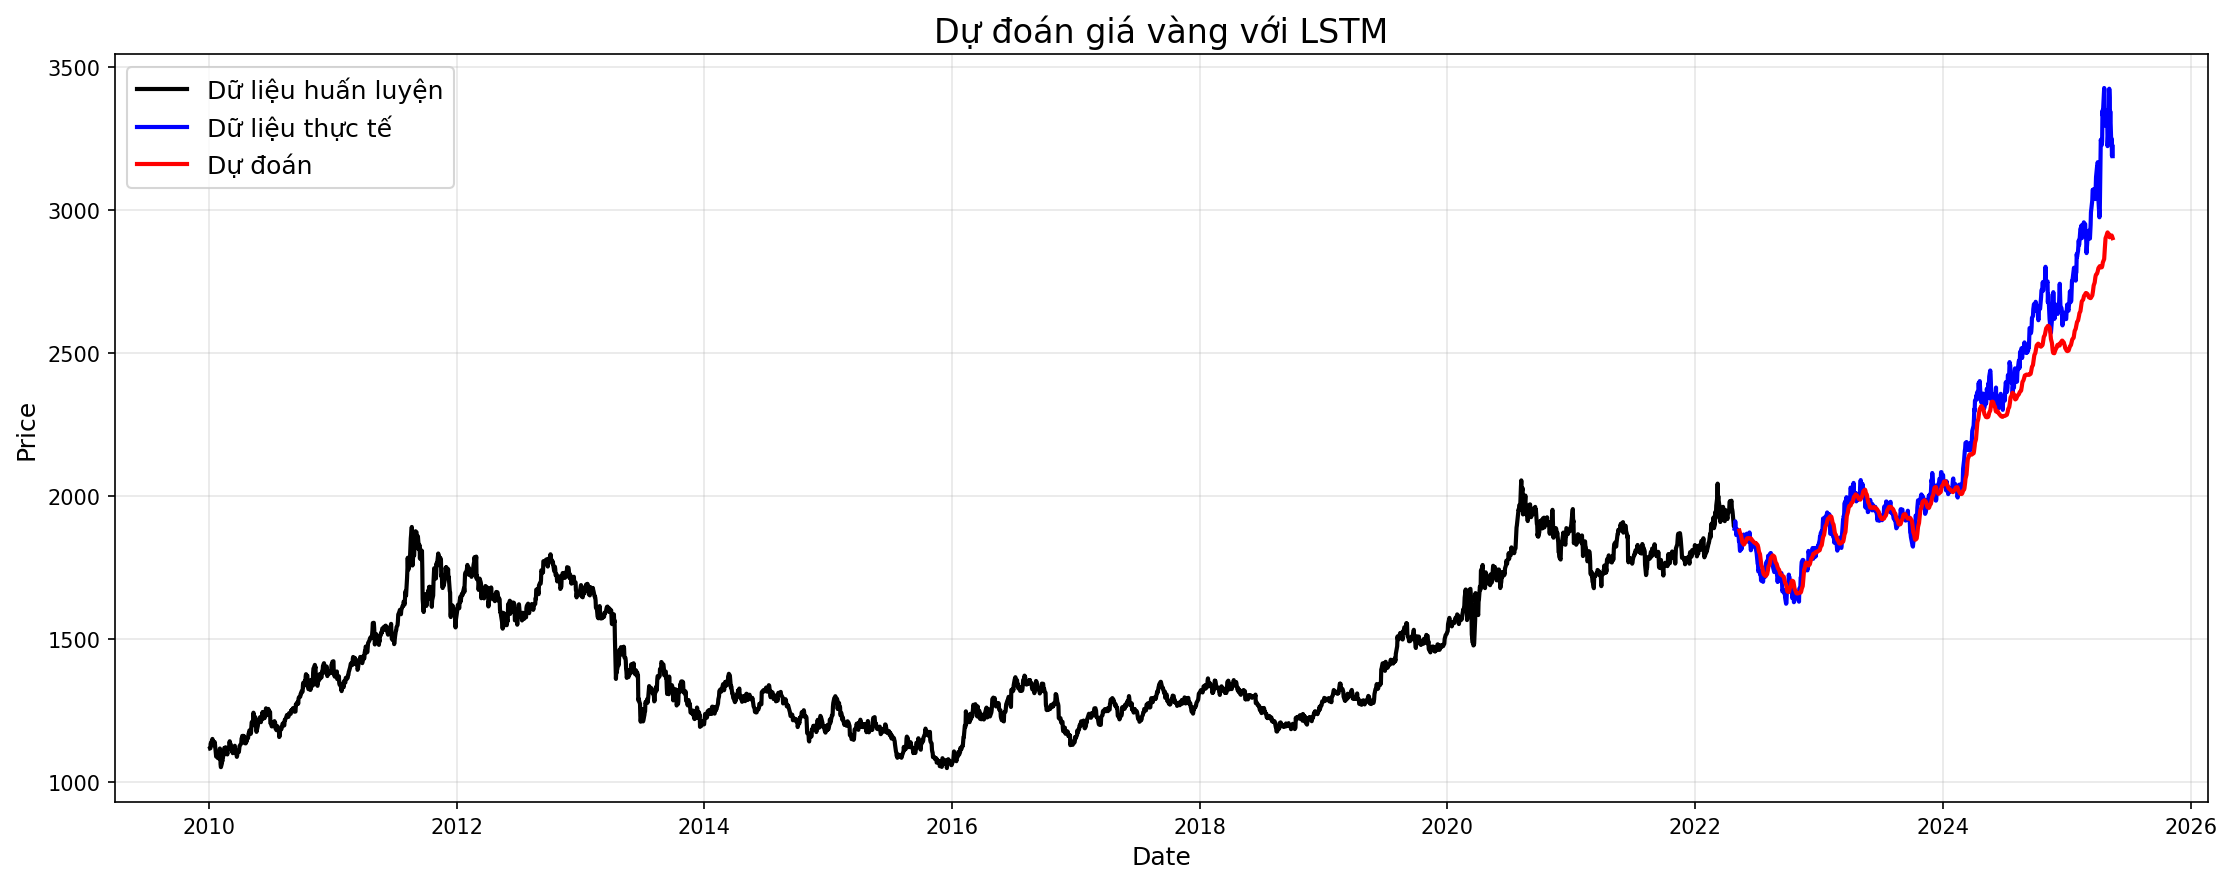

In [9]:
# Vẽ biểu đồ kết quả
plt.figure(figsize=(15, 6), dpi=150)

# Tạo mảng date cho dữ liệu test (đã có các chỉ mục ngày)
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]

# Vẽ dữ liệu train (chỉ hiển thị giá Price từ dữ liệu huấn luyện)
# Tạo mảng giả để lấy giá trị Price thực tế
dummy_train = np.zeros((len(train_data), 4))
dummy_train[:,0:4] = train_data  # Sao chép dữ liệu train đầy đủ 4 features
train_values = scaler.inverse_transform(dummy_train)[:,0].reshape(-1, 1)  # Lấy cột Price (cột đầu tiên)
plt.plot(train_dates, train_values, color='black', lw=2, label='Dữ liệu huấn luyện')

# Vẽ dữ liệu test thực tế (chỉ hiển thị giá Price từ dữ liệu test)
dummy_test = np.zeros((len(test_data), 4))
dummy_test[:,0:4] = test_data  # Sao chép dữ liệu test đầy đủ 4 features
test_values = scaler.inverse_transform(dummy_test)[:,0].reshape(-1, 1)  # Lấy cột Price (cột đầu tiên)
plt.plot(test_dates[:len(test_values)], test_values, color='blue', lw=2, label='Dữ liệu thực tế')

# Vẽ dữ liệu dự đoán (cần điều chỉnh ngày)
test_dates_pred = test_dates[time_step:len(test_dates)]
plt.plot(test_dates_pred[:len(predictions_rescaled)], predictions_rescaled, color='red', lw=2, label='Dự đoán')

plt.title('Dự đoán giá vàng với LSTM', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()
